Comparing Boosting and Bagging Techniques With Noisy and Imbalanced Data
https://ieeexplore.ieee.org/document/5645694?arnumber=5645694


In [15]:
import numpy as np
from numpy.random import sample
import pandas as pd
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold, cross_val_predict, StratifiedKFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from scipy import interp
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report, f1_score, auc
from sklearn.metrics import average_precision_score, roc_curve, auc, accuracy_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.utils import resample
import matplotlib.pyplot as plt
from scipy import interp
%matplotlib inline

In [16]:
df = pd.read_csv("SCI.csv")#, sep='COLUMN_SEPARATOR', dtype=np.float64)
df.set_index('StudyID', inplace=True)
y = df.FU_SA
X = df.drop('FU_SA', axis=1)
df.shape

(591, 50)

In [24]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

In [26]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

    Specs      Score
5    STS6  31.154624
30  STS32  21.996316
7    STS8  20.414031
45  STS48  17.093917
4    STS5  16.712957
24  STS26  15.565800
20  STS22  13.507376
46  STS49  13.041290
15  STS17  12.388857
42  STS45  12.220711


[0.04062448 0.03210861 0.01362129 0.0078754  0.02528418 0.03157291
 0.03089564 0.01287464 0.02372348 0.02370735 0.02806177 0.00972765
 0.01797847 0.01909941 0.01481223 0.01555996 0.01515273 0.02616131
 0.02920462 0.02013652 0.02967754 0.01425713 0.01023294 0.02925781
 0.02146842 0.00900541 0.02900938 0.01396764 0.01790286 0.0255614
 0.0356357  0.02209619 0.00331065 0.01769829 0.01706083 0.01425843
 0.02620482 0.01422743 0.03040567 0.019183   0.02590892 0.0282042
 0.02688322 0.01720744 0.02243608 0.01546057 0.02529536]


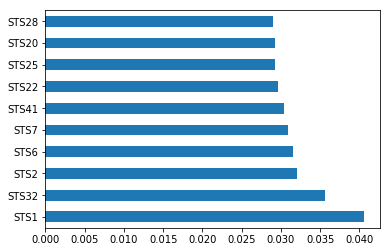

In [27]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

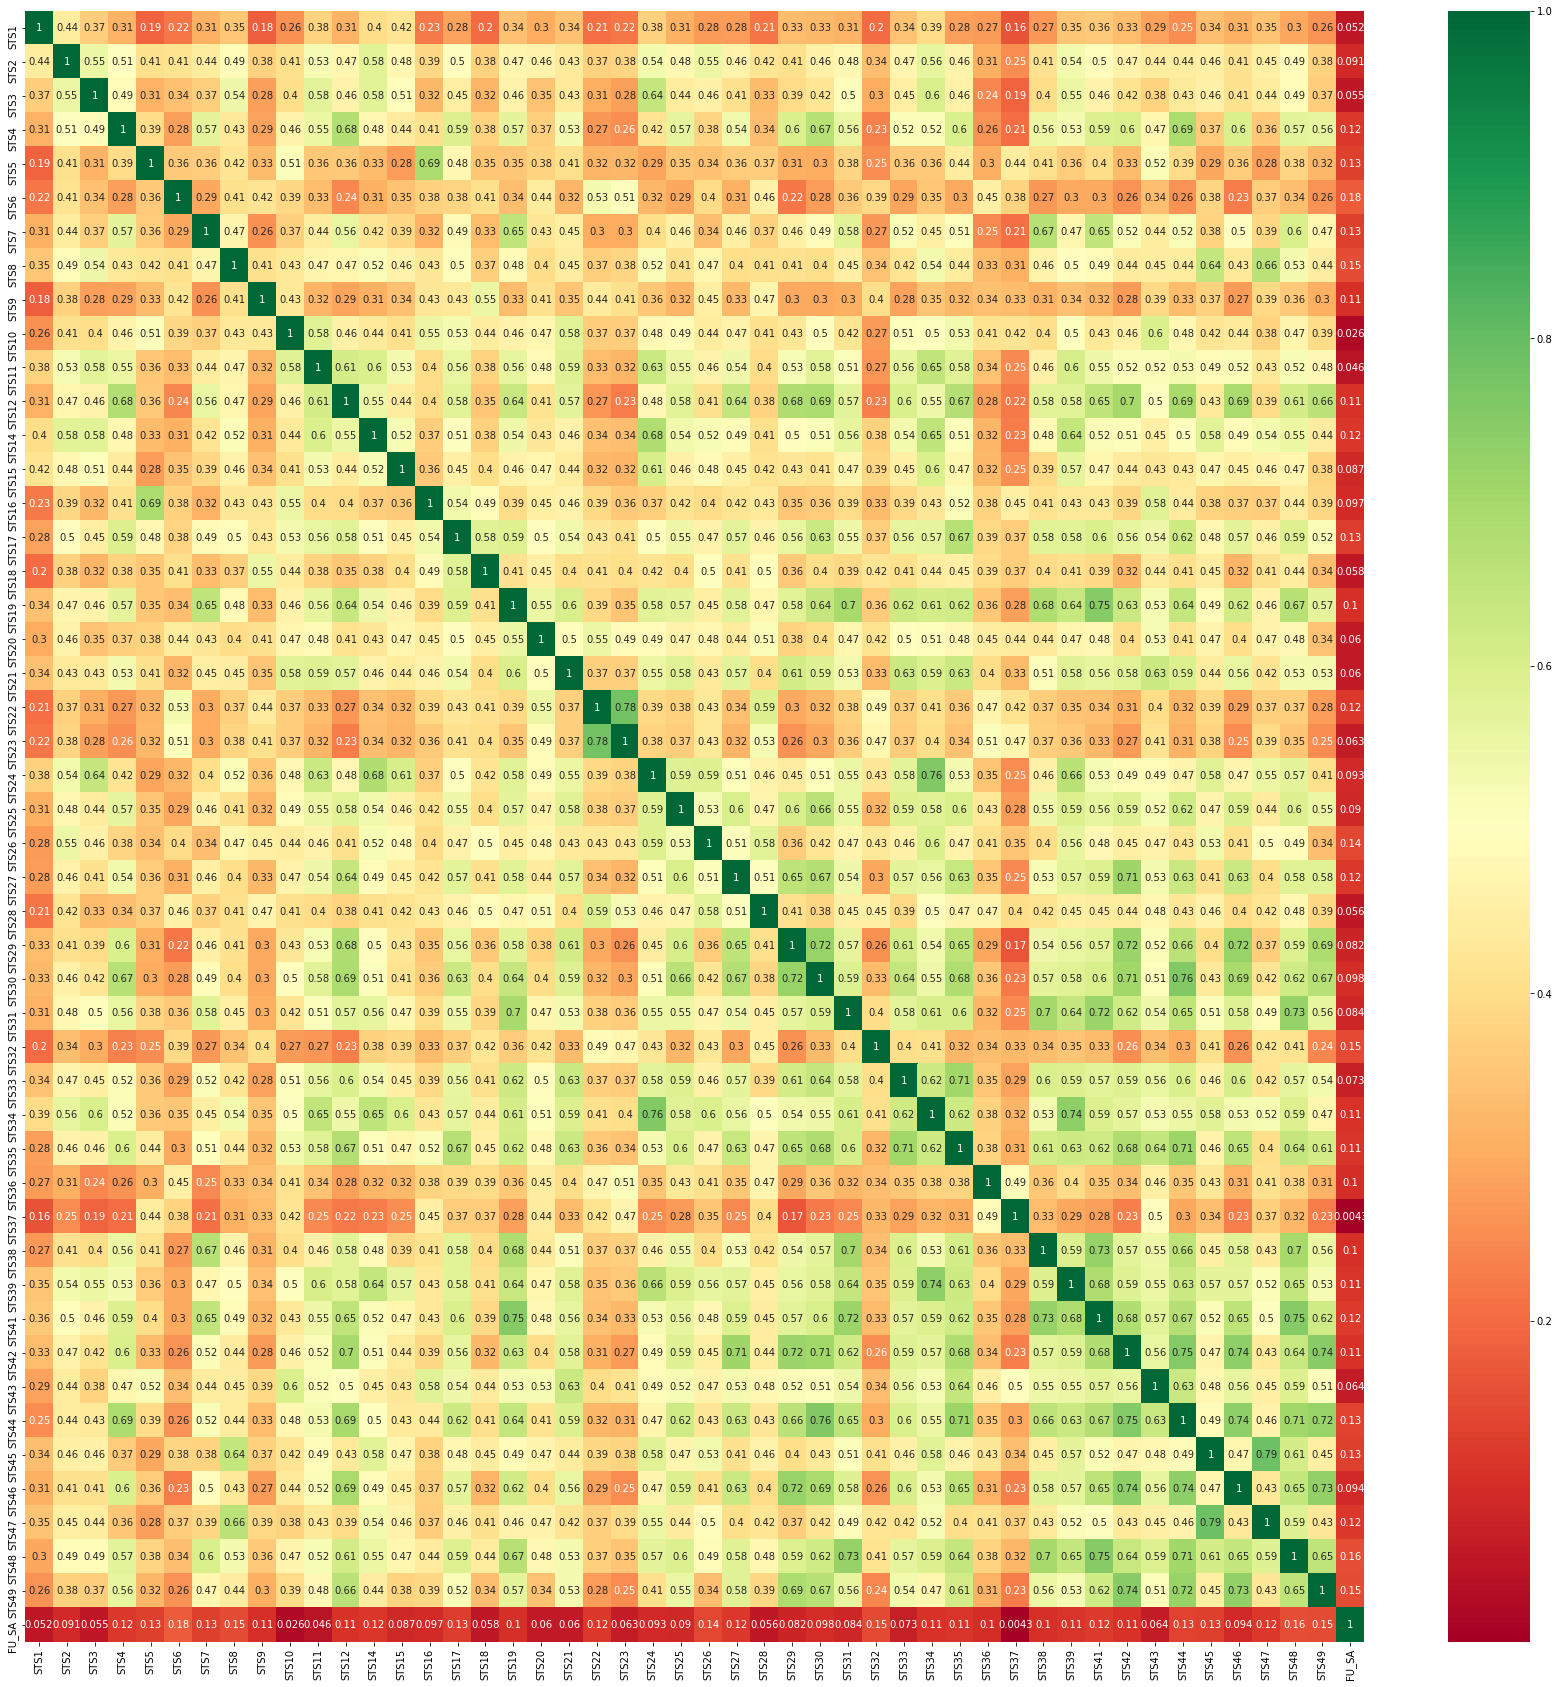

In [32]:
import seaborn as sns
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(30,30))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# LR

In [19]:
logreg = LogisticRegression()

logreg.fit(X,y)

preds = logreg.predict(X)

C_app = roc_auc_score(y, preds)

## Bootstrapping ##

B = 11

Cb_boots = []
Cb_orig = []
opts = []



for i in range(1, B):
    boot = resample(df, replace=True, n_samples=len(X)) #Create bootstrapped dataset
    y_b = boot.FU_SA 
    X_b = boot.drop('FU_SA', axis=1)
    logreg.fit(X_b, y_b) #Fit LR using boostrapped data
    preds_b = logreg.predict(X_b) #Make predictions on bootstrapped data
    roc_b = roc_auc_score(y_b, preds_b) 
    Cb_boots.append(roc_b)
    preds_orig = logreg.predict(X) #Apply model from boostrapped data to original data
    roc_o = roc_auc_score(y, preds_orig)
    Cb_orig.append(roc_o)
    opts.append(roc_b - roc_o)
    
O = 1/B * np.sum(opts)
O_adj = C_app - O
print(C_app)
print(O)
print('Adj AUC', O_adj)

0.6491243432574431
0.09086465212102542
Adj AUC 0.5582596911364176


# RF

In [20]:
rf = RandomForestClassifier(n_estimators = 7)

rf.fit(X,y)

preds = rf.predict(X)

C_app = roc_auc_score(y, preds)

## Bootstrapping ##

B = 11

Cb_boots = []
Cb_orig = []
opts = []

for i in range(1, B):
    boot = resample(df, replace=True, n_samples=len(df)) #Create bootstrapped dataset
    y_b = boot.FU_SA 
    X_b = boot.drop('FU_SA', axis=1)
    rf.fit(X_b, y_b) #Fit LR using boostrapped data
    preds_b = rf.predict(X_b) #Make predictions on bootstrapped data
    roc_b = roc_auc_score(y_b, preds_b) 
    Cb_boots.append(roc_b)
    preds_orig = rf.predict(X) #Apply model from boostrapped data to original data
    roc_o = roc_auc_score(y, preds_orig)
    Cb_orig.append(roc_o)
    opts.append(roc_b - roc_o)
    
O = 1/B * np.sum(opts)
O_adj = C_app - O
print(C_app)
print(O)
print('Adj AUC', O_adj)

0.875
0.20300501676383184
Adj AUC 0.6719949832361681


# Stratified bootstrapping

In [21]:
for region, df_region in df.groupby('FU_SA'):
    print(df_region)

         STS1  STS2  STS3  STS4  STS5  STS6  STS7  STS8  STS9  STS10  ...  \
StudyID                                                               ...   
2031        3     3     3     3     2     2     1     2     1      1  ...   
2039        2     2     4     0     3     2     1     0     0      0  ...   
2040        1     2     4     1     0     0     0     0     0      2  ...   
2048        0     1     1     0     0     2     0     0     0      0  ...   
2052        4     3     3     1     1     0     2     1     0      2  ...   
2053        4     3     3     3     1     1     2     4     2      0  ...   
2056        4     1     2     0     2     0     0     0     1      2  ...   
2058        2     0     2     0     0     0     0     0     0      0  ...   
2062        4     4     1     0     4     2     3     2     0      3  ...   
2065        4     1     2     0     2     3     0     2     0      1  ...   
2075        4     3     2     1     0     0     0     1     1      0  ...   